EFL: 29.34467872055943
BFL: 19.476537108480223
F/#: 1.1737871521103247
TSA: -0.6272150194149602
TCO: 0.13441827623400693
TAS: -3.759888214106905
SAS: -1.7598375006610532
PTB: -0.759812143938127
DST: -0.36299704630469604
TCV    0.117388
SCV    0.054944
PCV    0.023722
dtype: float64
0: Object (DummyInterface): Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1: Object space (AirGap): Gap(t=10000000000.0, medium=<opticalglass.opticalmedium.Air object at 0x7f8f391ab670>)
2: E1 (Element): Element: Spherical(c=0.00485767026134266), Spherical(c=-0.00485767026134266), t=5.0500, sd=24.5000, glass: N-BK7
3: AG6 (AirGap): Gap(t=0, medium=<opticalglass.opticalmedium.Air object at 0x7f8f391ab670>)
4: E2 (Element): Element: Spherical(c=0.00485767026134266), Spherical(c=-0.00485767026134266), t=5.0500, sd=24.5000, glass: N-BK7
5: AG1 (AirGap): Gap(t=5, medium=<opticalglass.opticalmedium.Air object at 0x7f8f391ab670>)
6: E4 (Element): Element: Spherical(c=-0.0038240917782026767), S

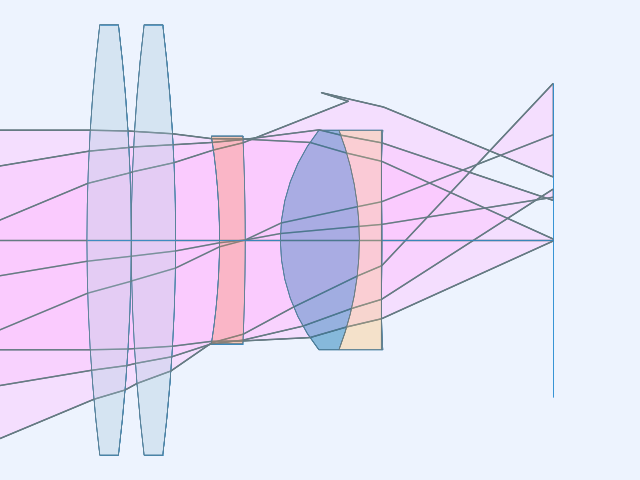

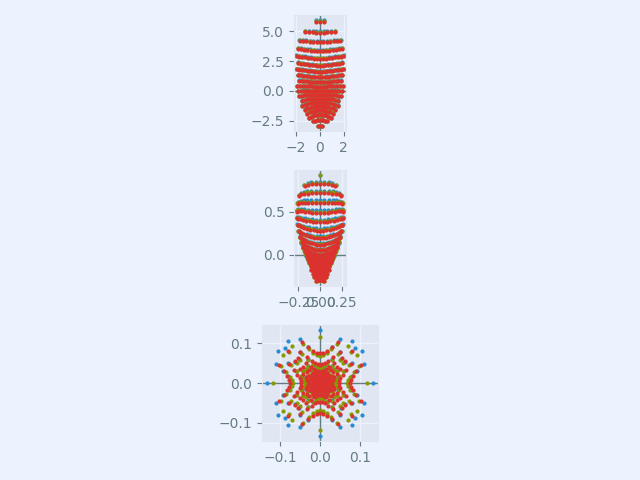

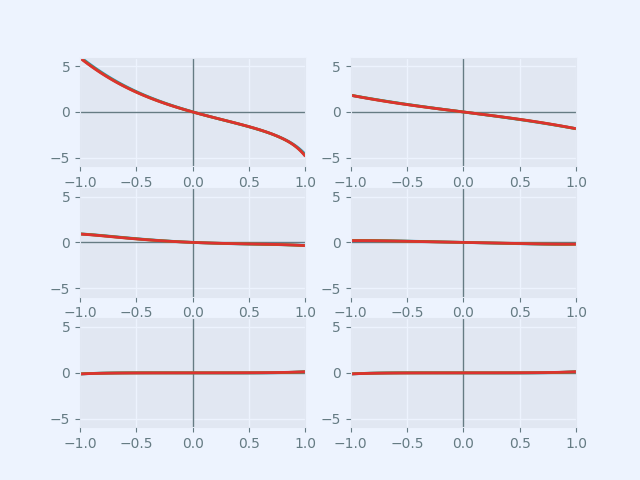

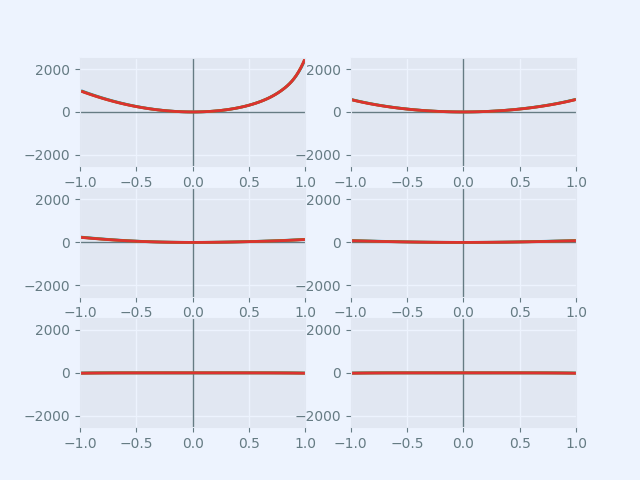

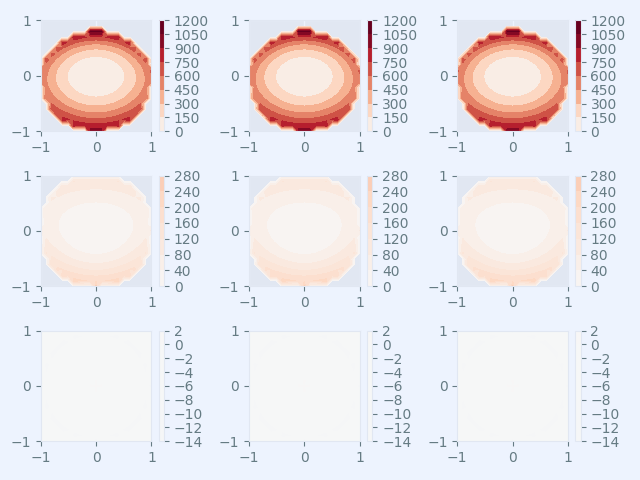

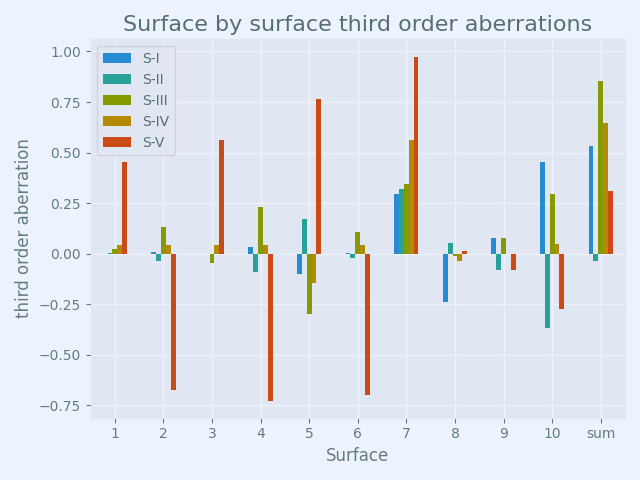

In [21]:
%matplotlib widget
isdark = False
from rayoptics.environment import *
from rayoptics.raytr.trace import apply_paraxial_vignetting


def SayaLens(gaps = [5,5,5,5], pupil=40, flds=[0,0.25,0.6]):
    opm = OpticalModel()
    opm.radius_mode = True
    
    osp = opm['optical_spec']
    osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=pupil)

    osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=63.0, flds=flds, is_relative=True)
    osp['wvls'] = WvlSpec([(486.1327, 0.5), (587.5618, 1.0), (656.2725, 0.5)], ref_wl=1)
    
    sm = opm['seq_model']    
    em = opm['ele_model']
    # Object distance
    sm.gaps[0].thi = 1e10
    
   
#    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_45169.zmx', t=gaps[0]) # 50x200
    
#    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_32921.zmx', t=gaps[0]) # 40x120 ACH  
#    opm.flip(opm['ele_model'].elements[2])

    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_45169.zmx', t=0) # 50x200
    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_45169.zmx', t=gaps[0]) # 50x200
    #opm.add_from_file('/Users/joshreich/src/lensStack/zmax_32980.zmx', t=gaps[0]) # 50x100
   
    #opm.add_from_file('/Users/joshreich/src/lensStack/glass_lens.roa', t=gaps[1]) # Old lens
    #opm.flip(em.elements[6])

    
    opm.add_from_file('/Users/joshreich/src/lensStack/left_lens.roa', t=gaps[2]) # EYE GLASS    
    opm.flip(em.elements[6])
    sm.ifcs[sm.cur_surface].max_aperture = 1
    sm.set_stop()

    

    
    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_49662.zmx', t=10) # 25x30 ASPH ACH VIS 0
    #opm.flip(opm['ele_model'].elements[6])
    em.elements[8].sd = 5
    
    opm.update_model()
    # Move the last element to the back focal length of the system
    sm.gaps[len(sm.gaps)-1].thi = opm['analysis_results']['parax_data'].fod.bfl 
    #sm.gaps[len(sm.gaps)-1].thi = 21.41
    opm.update_model()
    
    apply_paraxial_vignetting(opm)
    
    return opm



def evaluateLens(opm, preamble='', CSV=True):
    ar = opm['analysis_results']
    pm = opm['parax_model']
    ax_ray, pr_ray, fod = ar['parax_data']
    to_pkg = compute_third_order(opm)
    n_last = pm.sys[-1][mc.indx]
    u_last = ax_ray[-1][mc.slp]
    ta = to.seidel_to_transverse_aberration(to_pkg.loc['sum',:], n_last, u_last)
    tc=to.seidel_to_field_curv(to_pkg.loc['sum',:], n_last, fod.opt_inv)

    
    if (CSV):
            print(preamble + ", " +
              str(ar['parax_data'].fod.efl) + ", " +
              str(ar['parax_data'].fod.bfl) + ", " +
              str(ar['parax_data'].fod.fno) + ", " +
              str(ta[0]) + ", " +
              str(ta[1]) + ", " +
              str(ta[2]) + ", " +
              str(ta[3]) + ", " +
              str(ta[4]) + ", " +
              str(ta[5])) 
    else:
            print ("EFL: " + str(ar['parax_data'].fod.efl))
            print ("BFL: " + str(ar['parax_data'].fod.bfl))
            print ("F/#: " + str(ar['parax_data'].fod.fno))
            print ("TSA: " + str(ta[0]))
            print ("TCO: " + str(ta[1]))
            print ("TAS: " + str(ta[2]))
            print ("SAS: " + str(ta[3]))
            print ("PTB: " + str(ta[4]))
            print ("DST: " + str(ta[5]))
            print (tc)

g0 = 5
g1 = 2
g2 = 4
g3 = 5
SayaModel = SayaLens(gaps=[g0,g1,g2,g3], pupil=25)
evaluateLens(SayaModel, str(g0) + ", " + str(g1) + ", " + str(g2) + ", " + str(g3), CSV=False)
    

pm = SayaModel['parax_model']
em = SayaModel['ele_model']
em.list_elements()
SayaModel['seq_model'].list_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=SayaModel, is_dark=isdark).plot()
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=SayaModel,  dpi=100, is_dark=isdark).plot()
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=SayaModel, data_type='Ray', scale_type=Fit.All_Same, is_dark=isdark).plot()
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=SayaModel, data_type='OPD', scale_type=Fit.All_Same, is_dark=isdark).plot()
abr_plt = plt.figure(FigureClass=WavefrontFigure, opt_model=SayaModel,  scale_type=Fit.All_Same, is_dark=isdark).plot()

ar = SayaModel['analysis_results']
to_pkg = compute_third_order(SayaModel)
fig, ax = plt.subplots()
ax.set_xlabel('Surface')
ax.set_ylabel('third order aberration')
ax.set_title('Surface by surface third order aberrations')
to_pkg.plot.bar(ax=ax, rot=0)
ax.grid(True)
fig.tight_layout()


In [345]:
pm.first_order_data()

efl               30.88
ffl              -9.068
pp1               21.81
bfl               18.94
ppk               11.93
f/#               1.235
m            -3.088e-09
red          -3.239e+08
obj_dist          1e+10
obj_ang               1
enp_dist          41.26
enp_radius         12.5
na obj         1.25e-09
n obj                 1
img_dist          18.94
img_ht           0.5389
exp_dist     -3.254e-07
exp_radius        7.669
na img          -0.3753
n img                 1
optical invariant       0.2182
